# I. Useful Libraries

## I.1. Installation

In [ ]:
!pip install -U pymoo

## I.2. Import

In [ ]:
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
from tqdm import tqdm
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import plotly.express as px
import plotly.graph_objects as go

# Nouvelle section

# II. Introduction

**The Internet of Things (IoT)** is one of the digital concepts that have greatly motivated the need for clean energy and autonomous management of computing and communication infrastructures. The Internet of Things consists of identifying and making everyday objects cooperate via the Internet to provide various digital services. The IoT is at the heart of a **massive generation of data and a hyper-use of computing and communication infrastructures**.
<br>
<br>
The exclusive use of Cloud Computing as a computing paradigm to support services in IoT environments is no longer feasible and faces many limitations including the overuse and overload of networks to communicate with data centers, the astronomical number of IoT services and the nature of traffic they generate (video, voice etc.), security issues and the near instantaneous response time requirements of IoT applications. **Fog Computing** has emerged as a solution that enables computing and communication infrastructures to meet **Quality of Service (QoS)** requirements and to intelligently and autonomously support the changes and dynamics induced by IoT environments. <br> 
<br>
Fog Computing is a **distributed computing paradigm** that aims to extend the computational and storage capabilities of the Cloud and bring services closer to the end users (IoT objects) by exploiting compute nodes located between these end users and remote data centers. Many researches have aspired to implement a strategy for **placing the services that make up Internet of Things applications on a Fog Computing infrastructure**. This is a finite state machine based strategy that uses three conflicting optimization objectives, namely **completion time, energy consumption and economic cost**, considering both computational and communication aspects, based on the metaheuristic **NSGA-II**. The method used is called **MAPO** which stands for Multi-Objective Model for IoT Application Placement in a Fog Environment.




# III. The problem

Our problem is represented as such (what follows is simply a summary of what was described by *Narges Mehran*, *Dragi Kimovski* and *Radu Prodan* [here](https://arxiv.org/pdf/1908.01153.pdf)):  <br><br>


  \begin{array}\\
      f_1(A,R) = min_{plc(A)=R} T(A,R) \\
      f_2(A,R) = min_{plc(A)=R} E(A,R) \\
      f_3(A,R) = min_{plc(A)=R} C(A,R) \\
      \forall m_{i} \in A, r_{j} = plc(m_{i})
  \end{array}

<br>

$$
CPU(m_i) < CPU_j  \\
MEM(m_i) < MEM_j \\
Data_i < STOR_j
$$


Where:

* $A = (M, \Sigma, \Gamma, Data_1, \eta)$ is an IoT application. 
  * $M$ is a set of $x$ interconnected components $M=\bigcup_{i=1}^x m_i$. 
  * $\Sigma$ is an alphabet representing all possible data items generated by all components $m_i \in M$
  * $\Gamma : M\times\Sigma \rightarrow M\times\Sigma$ is a transition function where $\Gamma(m_i, Data_i) = (m_j, Data_j)$ represents the outcome of processing the data item $Data_i$ using component $m_i$ and producing a new data item $Data_j$ to be transferred and processed by the successor $m_j$
  *$Data_1$ is the input data received by the start component $m_1$ from the IoT devices which triggers the first transition $\Gamma(m_1, Data_1)$ 
  *$\eta \subset M$ is a set of accepting components
<br>
<br>

* $R \subset RS$ is our set of fog devices.
  * $RS = \bigcup_{i=1}^y r_j$ is a set of heterogeneous fog devices defined by $r_j = (CPU_j, MEM_j, STOR_j)$ such as:
    * $CPU_j$ is the number of instructions $INSTR(m_i)$ per second (the processing speed) 
    * $MEM_j$ is the memory size
    * $STOR_j$ is the permanent storage size available
<br>
<br>

* $plc : A \rightarrow R$ is the placement of an IoT application $A$ on a set of fog devices $R$. $plc$ maps each component $m_i \in A$ on a device $r_j \in R$. Therefore, $R=plc(A)$ is the set of devices where the application runs.
<br>
<br>

* $T$, $E$ and $C$ are respectively the completion time, energy consumption and economic cost. They are defined as such:

> **The completion time $T$** : <br>
  > For a single component $m_i$ mapped on a device $r_j=plc(m_i)$, the completion time is defined as such:
\begin{align}
        \text{T}(m_i,r_j) = \left\{
        \begin{array}{cl}
        t(m_i,r_j) = \frac{INSTR(m_i)}{CPU_j} & pred(m_i)=\varnothing \\
        T(pred(m_i), r_k) + \frac{Data_i}{BW_{k,j}}+t(m_i,r_j) & pred(m_i) \ne \varnothing.
        \end{array}
        \right.
    \end{align}
> 
> <br>
> Where $pred(m_i)$ is the predecessor of $m_i$ and $r_k=plc(pred(m_i))$, and $t(m_i, r_j)$ is the computation time of $m_i$, and $BW_{k,j}$ is the network bandwidth between $r_k$ and $r_j$. Therefore the total completion time of an application A placed on the set of fog devices $R = plc(A)$ is: 
> <br>
> <br>
$$
T(A,R) = T(m_x,plc(m_x)) 
$$
>
> Where $m_x$ is simply the set of components with predecessors (which means that $succ(m_x)$ is empty)

<br>
<br>

> **The energy consumption $E$** : <br>
> For a single component $m_i$, the energy consumption of $m_i$ on a device $r_j$ is defined as:
> <br>
> <br>
$$
E(m_i,r_j) = E_p(m_i, r_j) + E_m(r_k,r_j) + E_s(m_i,r_j)
$$
> <br>
Where $E_p(m_i,r_j)$ is the computation energy, $E_m(r_k,r_j)$ is the communication energy (to retrieve data from the predecessor placed on $r_k = plc(pred(m_i))$, and $E_s(m_i,r_j)$ is the static energy for maintaining the device active. They are defined as such:
> <br>
> <br>
$$
E_p(m_i,r_j) = \rho_{j}^p . t(m_i, r_j) \\
E_m(r_k,r_j) = \rho_{j}^m . \frac{Data_i}{BW_{k,j}} +ϵ_j
$$
> <br>
> Where $\rho_j^p$ (resp. $\rho_j^m$) is the computational power consumption (resp. the power of consumption) of $r_j$ . Therefore, the total energy of an application $A$ placed on the set of fog devices $R=plc(A)$ is:
><br>
><br>
$$
E(A,R)=\sum_{\forall m_i \in A  \wedge plc(m_i)=r_j} E(m_i,r_j)
$$
 
<br>
<br>

>**The economic cost $C$**: <br>
>For a single component $m_i$, the economic cost $C(m_i,r_j)$ of executing it on $r_j$ is the sum of its processing, storage and communication costs: 
$$
C(m_i, r_j) = t(m_i,r_j).CP_j + Data_i.CS_j + \frac{Data_i}{BW_{k,j}}.CR_j
$$
> <br>
> <br>
> Where $CP_j$, $CS_j$, and $CR_j$ are the processing, storage and communication costs of device $r_j$ per second. Therefore the total cost of executing an application $A$ on a set of fog devices $R$ is:
$$
C(A,R) = \sum_{\forall m_i \in A \wedge plc(m_i)=r_j} C(m_i, r_j)
$$

# III. NSGA-II Explained

Our goal here is, like for all multi-objective optimization problems, to find the fittest solution for a defined multi-dimensional problem. Let's first have a look at how the NSGA-II algorithm achieves that.

## III.1. Main principles of the algorithm

The principle of Darwin's "*Survival of the fittest*" is used to determine the fittest solution for our defined problem. The fittest value is equal to the performance of the outputs of our system. The algorithm goes as follows:


1.   **Create offspring** and combined population Rt
2.   **Rank and sort** offspring due to performance on defined target indicators
3.   **Take best members** to create new population including a good spread in solutions



In our case, our system is our **fog environment**, our outputs are the individuals where we get the fitness from the **completion time**, the **energy consumption** and the **economic cost** we need, and the genes which cause the survival of the fittest are our input parameters (number of instructions per second, the memory size, the permanent storage size...). Our population is simply a **set of application components and fog devices** to be placed, for each individual of our population, we know its input parameters. 

In other words, NSGA-II will  search for **a set of non-dominated Pareto placements of the application components on a set of Fog devices**.






## III.2. Detailed description

The NSGA-II algorithm performs the following steps iteratively until the increase/decrease of the target indicators reaches a limit, or until we reach a certain maximum number of iterations:



1.   **Non-Dominated Sorting**: <br>
Our starting point is a population containing a set number of individuals. Each individual differs in its gene (parameters) and for each one of them, the value of the target indicators are calculated (or simulated) which means that we know for each individual of the population $P_t$ how the performance of our target indicators is. <br> <br>
Out of this existing population $P_t$, an offspring population $Q_t$ is created by mixing the genes of better performing individuals and causing mutations. The new population is therefore a population that is twice the size of the parent population $P_t$. <br> <br>
Every individual is then ranked based on its performance regarding the target indicators, the better the performance the better it is ranked. This ranking occurs in different fronts (F1, F2, F3...). The smaller the number of the front, the better the performance of its individuals.

![nsga2.PNG](https://i0.wp.com/oklahomaanalytics.com/wp-content/uploads/2017/10/fig4.png)

  The new population is chosen by picking all individuals of the best fronts until the size of the original population is reached.

2. **Crowding distance sorting**: <br>
In one front, all individuals have the same performance. Therefore, if the last best front is too big and not all its individuals can fit in the new parent population, we use crowding distance sorting to pick some individuals to fill up the population of the next generation until it reaches its original size.




## III.3. Non-Dominated Sorting, how does it work?

Each point in the graphic below represents **an individual of the population.** The goal of non-dominated sorting is to find out which individual belongs in which front.

![image.png](https://images2018.cnblogs.com/blog/1378276/201804/1378276-20180417164252553-562835629.png)

For every individual in the population $R_t = P_t \cup Q_t$,  every individual is compared with every other individual : we check pairwise if the individual is dominated by the other one or vice versa. Then, we count for each individual how many individuals dominate him (**domination count**) and we create **a list that contains all individuals that are dominated by him**.

Based on this information, we can start our sorting process. Our goal is to find different fronts. To find the first front (F1), we just take all individuals that  have a **domination count of 0** (dominated by none of the other individuals). 

Then, to find the next front, we once again iterate through the individuals in front F1. Since all of them have a list containing all individuals they dominate, iterating through all of these lists, **for every individual being in one of these lists, we substract 1 to their domination count**. Therefore, all individuals which are only dominated by individuals in F1 are going to have a domination count of 0. So again, our front F2 is going to be the individuals with a domination count of 0.

We keep repeating the same procedure until all our individuals are stored in fronts. This way, we would have ranked all individuals in our population $R_t$.

## III.4. What is Crowding Distance?

![crowding-distance.png](https://www.researchgate.net/publication/333912634/figure/fig1/AS:772037362601984@1561079459639/Concept-of-non-dominated-sorting-and-crowding-distance-approaches.ppm)

In order to keep a good spread in NSGA-II and avoid local maxima instead of finding the global ones, **the crowding distance factor decides which individuals are added to the new population.** The individuals with a higher crowding distance are picked first. The total crowding distance for each individual is the sum of all distances for every single target indicator (in the picture above, we have two target indicators f1 and f2).

First, the front is sorted regarding every single target indicator. For every target indicator, the individuals with the smallest and the biggest value for this indicator get a very high distance value. The distance of the other individuals is calculated by taking the distance value of the neighbour objectives (as it is showed in the picture).

The individuals with the highest distance value are chosen and passed to the next population.

# IV. NSGA-II Implementation

## IV.1. Our use case

We're gonna take the example of a **mental health care application** called **MHC-PMS**.

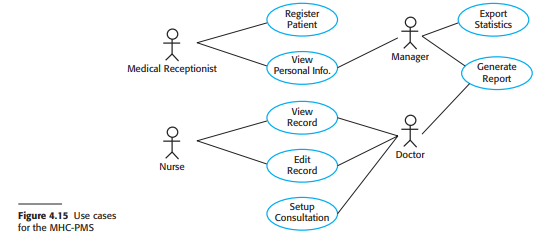

It is used in a number of UK hospitals for **managing patient information** for patients suffering from a mental health disorder. As such patients may not always want to attend the same clinic, they must be helped and supported through prearranged appointments, and emergency services orchestrated in the **Fog environment below**.

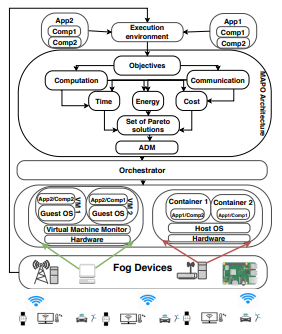

### IV.1.a. Application Requirements

Every element of the dictionnary below gives the **requirements** (CPU, Memory, Storage etc.) of a feature of our **MHC-PMS** application.

In [ ]:
# x=7 application components

application= {}

application['DetMentStat']={
            'id_i': '0',
            'CPU_i':'200',
            'MEM_i':'100',
            'STOR_i':'256',
            'Data_i':'125'}

application['DecomSaftConcern']={
            'id_i': '1',
            'CPU_i':'500',
            'MEM_i':'200',
            'STOR_i':'256',
            'Data_i':'125'}


application['GenMedRec']={
            'id_i': '2',
            'CPU_i':'200',
            'MEM_i':'200',
            'STOR_i':'256',
            'Data_i':'125'}


application['ViPatHist']={
            'id_i': '3',
            'CPU_i':'1000',
            'MEM_i':'100',
            'STOR_i':'512',
            'Data_i':'65'}

application['Summ']={
            'id_i': '4',
            'CPU_i':'2000',
            'MEM_i':'300',
            'STOR_i':'512',
            'Data_i':'125'}

application['MentHealthAct']={
            'id_i': '5',
            'CPU_i':'200',
            'MEM_i':'500',
            'STOR_i':'256',
            'Data_i':'500'}

application['FindenKlinik']={
            'id_i': '6',
            'CPU_i':'200',
            'MEM_i':'200',
            'STOR_i':'256',
            'Data_i':'125'}

### IV.1.b. Resources

The two tables below give the range of numerical data we used to simulate our fog devices.

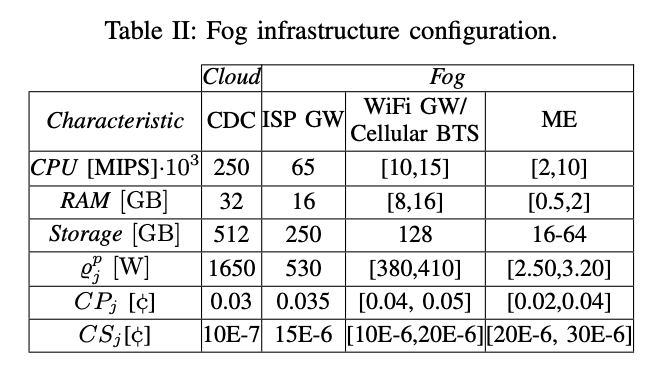

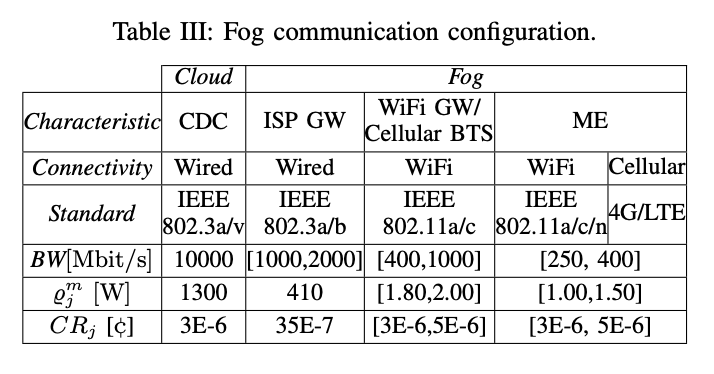

We define a dictionnary called resources that contains the data shown in the tables above:

In [ ]:
# y = 5 devices
resources= {}

resources['cloud']={
            'id_j': '0',
            'CPU_j':'29491',
            'MEM_j':'1024',
            'STOR_j':'256',
            'BW_j':'1024',
            'CP_j':'0.00035',
            'CS_j':'0.00000015',
            'CR_j': '0.00000004',
            'rho_m': '1300',
            'rho_p':'1650'}

resources['proxy']={
            'id_j': '1',
            'CPU_j':'1400',
            'MEM_j':'1024',
            'STOR_j':'256',
            'BW_j':'1024',
            'CP_j':'0.00035',
            'CS_j':'0.00000015',
            'CR_j': '0.00000004',
            'rho_m': '410',
            'rho_p': '530'}

resources['m-0-0']={
            'id_j': '2',
            'CPU_j':'1400',
            'MEM_j':'1024',
            'STOR_j':'512',
            'BW_j':'1024',
            'CP_j':'0.00025',
            'CS_j':'0.0000001',
            'CR_j': '0.00000006',
            'rho_m': '2',
            'rho_p': '380'}

resources['m-0-1']={
            'id_j': '3',
            'CPU_j':'1400',
            'MEM_j':'1024',
            'STOR_j':'512',
            'BW_j':'1024',
            'CP_j':'0.00045',
            'CS_j':'0.00000018',
            'CR_j': '0.00000004',
            'rho_m': '1',
            'rho_p':'3.10'}

resources['m-0-2']={
            'id_j': '4',
            'CPU_j':'1400',
            'MEM_j':'1024',
            'STOR_j':'256',
            'BW_j':'1024',
            'CP_j':'0.00040',
            'CS_j':'0.00000015',
            'CR_j': '0.000000035',
            'rho_m': '1.5',
            'rho_p': '2.8'}

## IV.2. Objective functions : First Draft

Before defining our population, and implementing the objective functions for an individual, we're going to start by implementing them for a couple (application component, fog device)

### IV.2.a. Completion time

\begin{align}
        \text{T}(m_i,r_j) = \left\{
        \begin{array}{cl}
        t(m_i,r_j) = \frac{INSTR(m_i)}{CPU_j} & pred(m_i)=\varnothing \\
        T(pred(m_i), r_k) + \frac{Data_i}{BW_{k,j}}+t(m_i,r_j) & pred(m_i) \ne \varnothing.
        \end{array}
        \right.
    \end{align}



In [ ]:
def t(m,r):
  return int(m.get('CPU_i'))/int(r.get('CPU_j'))

def completion_time(m,r):
  i = int(m.get('id_i'))
  if i==0:
    return t(m,r)
  else:
    m_pred = [c for c in application.values() if int(c.get('id_i'))==i-1][0]
    return t(m_pred,r) + int(m.get('Data_i'))/int(r.get('BW_j')) + t(m,r)

### IV.2.b. Energy consumption

$$
E(m_i,r_j) = E_p(m_i, r_j) + E_m(r_k,r_j) + E_s(m_i,r_j)
$$

In [ ]:
def energy_consumption(m,r):
  return float(r.get('rho_p'))*t(m,r) + float(r.get('rho_m'))*(int(m.get('Data_i'))/int(r.get('BW_j')))*float(r.get('CR_j'))

### IV.2.c. Economic cost

$$
C(m_i, r_j) = t(m_i,r_j).CP_j + Data_i.CS_j + \frac{Data_i}{BW_{k,j}}.CR_j
$$

In [ ]:
def economic_cost(m,r):
  return t(m,r)*float(r.get('CP_j')) + int(m.get('Data_i'))*float(r.get('CS_j')) + (int(m.get('Data_i'))/int(r.get('BW_j')))*float(r.get('CR_j'))

## IV.3. How can we define our population?

Each **individual is a placement of our components on the fog devices**, which means that our population is a group of placements.

We define a placement as a matrix $P$ of size $7\times5$ (7 components and 5 devices) where $P_{i,j}$=1 if $m_i$ is placed on $r_j$ and 0 if not. Here's an example:
<br>
$$
P =
 \begin{pmatrix}
  1 & 0 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 & 0
 \end{pmatrix}
$$
<br>


Here's a function to get the list placement couples $(m_i, r_j)$ from a placement matrix P:

In [ ]:
def get_placement(P):
  placements = np.where(P==1)
  components = pd.Series(placements[0]).map(lambda x: [c for c in application.values() if c.get("id_i")==str(x)][0])
  devices = pd.Series(placements[1]).map(lambda x: [c for c in resources.values() if c.get("id_j")==str(x)][0])
  return list(zip(components, devices))

We also need a function to make sure the placement respects the constraints of the problem, defined below.

$$
CPU(m_i) < CPU_j  \\
MEM(m_i) < MEM_j \\
Data_i < STOR_j
$$

In [ ]:
def get_placement_respects_constraints(P):
        # Make sure the placement matrix respects the constraints
        P_new = P
        placement = get_placement(P)
        for a,r in placement:
          if (int(a.get('CPU_i')) >= int(r.get('CPU_j'))) or (int(a.get('MEM_i')) >= int(r.get('MEM_j'))) or (int(a.get('Data_i')) >= int(r.get('STOR_j'))):
            i1 = int(a.get('id_i'))
            i2 = int(r.get('id_j'))
            P_new[i1,i2] = 0
            indices2_elligibles =[]
            for indice in range(len(resources)):
              res_indice = [c for c in resources.values() if int(c.get('id_j'))==indice][0]
              if (int(a.get('CPU_i')) < int(res_indice.get('CPU_j'))) and (int(a.get('MEM_i')) < int(res_indice.get('MEM_j'))) and (int(a.get('Data_i')) < int(res_indice.get('STOR_j'))):
                indices2_elligibles.append(indice)
            
            i2_new = random.choice(indices2_elligibles)
            P_new[i1, i2_new] = 1
        return P_new

Let's test it on our matrix P defined above.

In [ ]:
P = np.array([[1,0,0,0,0], 
             [0,1,0,0,0], 
             [0,0,1,0,0],
             [0,0,0,1,0],
             [0,0,0,0,1],
             [1,0,0,0,0],
             [0,1,0,0,0]])

get_placement_respects_constraints(P)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

## IV.4. Objective functions

Therefore, our objective functions, for a placement $P$, are defined as such :

In [ ]:
# Completion Time
def T(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  s = 0
  for m_i,r_j in placement:
    s+=completion_time(m_i, r_j)
  return s

# Energy Consumption
def E(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  s = 0
  for m_i,r_j in placement:
    s+=energy_consumption(m_i, r_j)
  return s

# Economic Cost
def C(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  s = 0
  for m_i,r_j in placement:
    s+=economic_cost(m_i, r_j)
  return s

## IV.5. Constraints

In [ ]:
def cpu_constraint(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  for a,r in placement:
    if (int(a.get('CPU_i')) >= int(r.get('CPU_j'))):
      return 1
  return -1

def mem_constraint(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  for a,r in placement:
    if (int(a.get('MEM_i')) >= int(r.get('MEM_j'))):
      return 1
  return -1

def stor_constraint(P):
  d = P[0].reshape(7,5)
  placement = get_placement(d)
  for a,r in placement:
    if (int(a.get('Data_i')) >= int(r.get('STOR_j'))):
      return 1
  return -1

# VI.6. NSGA-II with Pymoo

Before starting to implement NSGA-II we define a list ```all_the_population``` which is going to contain all the placements we randomly generated and used to find an optimum.



In [ ]:
all_the_population = []

Since we are using Python's ```pymoo``` library, and following the [documentation](https://pymoo.org/), we first need to define our problem class which contains the objective functions, the constraints as well as some informations about our input (size and number of variables)


In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self, size=35):
        super().__init__(n_var=1, n_obj=3)
        self.size = size

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = T(x)
        f2 = E(x)
        f3 = C(x)

        out["F"] = np.array([f1,f2,f3])

Then, the class below defines how we want to do our sampling. Sampling simply means creating a random population of a given size.

In [ ]:
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
      X = np.full((n_samples, 1), None, dtype=object)

      for i in range(n_samples):
        #Generate a random placement
        Pl = np.random.randint(0, 1, size=(7,5))
        for j in range(Pl.shape[0]):
          if Pl[j].sum()<1:
            Pl[j, np.random.randint(0,4)] = 1
        
        X[i,0] = get_placement_respects_constraints(Pl).flatten()
      all_the_population.extend(X)
      return X

After that, we define how we want to cross and mutate our individuals.

In [ ]:
class MyCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):

        # The input of has the following shape (n_parents, n_matings, n_var)

        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)

        # for each mating provided
        for k in range(n_matings):

            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]

            # prepare the offsprings
            off_a = np.zeros((7,5))
            off_b = np.zeros((7,5))

            reshaped_a = a.reshape(7,5)
            reshaped_b = b.reshape(7,5)

            for i in range(7):
              for j in range(5):
                if np.random.random() < 0.5:
                    off_a[i,j] = reshaped_a[i,j]
                    off_b[i,j] = reshaped_b[i,j]
                else:
                    off_a[i,j] = reshaped_b[i,j]
                    off_b[i,j] = reshaped_a[i,j]
            
            off_a = get_placement_respects_constraints(off_a).flatten()
            off_b = get_placement_respects_constraints(off_b).flatten()
            # set the output
            Y[0, k, 0], Y[1, k, 0] = off_a, off_b

        return Y

In [ ]:
class MyMutation(Mutation):
    def __init__(self):
        super().__init__()

    def _do(self, problem, X, **kwargs):
      # for each individual
      for i in range(len(X)):
        r = np.random.random()
        
        # with a probabilty of 40% - permute the placement matrix
        if r < 0.4:
          X[i,0] = get_placement_respects_constraints(np.random.permutation(X[i,0].reshape(7,5))).flatten()
          
        # also with a probabilty of 40% - change a character randomly
        elif r < 0.8:
          x = X[i,0].reshape(7,5)
          i1 = random.randrange(x.shape[0])
          i2 = random.randrange(x.shape[1])
          x[i1,i2] = 0 if x[i1,i2]==1 else 1
          X[i,0] = get_placement_respects_constraints(x).flatten()
      
      
      return X

Then the class below allows us to eliminate the duplicates in our population.

In [ ]:
class MyDuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, a, b):
      value_bool = (a.X[0][0] == b.X[0][0])
      return value_bool

# V. Running NSGA-II

We run NSGA-II with a **population size of 100** and a **number of generations of 1000**.

In [ ]:
# Optimize
algorithm = NSGA2(pop_size=100,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  eliminate_duplicates=MyDuplicateElimination())

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 1000),
               seed=1,
               save_history=True,
               verbose=False)

# VI. Visualisation of the results

Let's see what placements our implementation of NSGA-II has selected.

In [ ]:
all_the_population = [c[0] for c in all_the_population]

f1_all_the_population = [T(np.array([x])) for x in all_the_population]
f2_all_the_population = [E(np.array([x])) for x in all_the_population]
f3_all_the_population = [C(np.array([x])) for x in all_the_population]

res_F_all_population = np.array([list(c) for c in list(zip(f1_all_the_population, f2_all_the_population, f3_all_the_population))])

df = pd.DataFrame(res_F_all_population, columns = ['T', 'E', 'C'])
df['optimal'] = 0
df2 = pd.DataFrame(res.F, columns = ['T', 'E', 'C'])
df2['optimal'] = 1
df = pd.concat([df, df2])
df.optimal = df.optimal.astype('category')

layout = go.Layout(
    showlegend=False,
    scene=go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='Time'),
        yaxis=go.layout.scene.YAxis(title='Energy'),
        zaxis=go.layout.scene.ZAxis(title='Cost')
    )
)



fig = go.Figure(data=[go.Scatter3d(
    x=df['T'].values,
    y=df['E'].values,
    z=df['C'].values,
    mode='markers',
    marker=dict(
        size=5,
        color=df['optimal'].astype(int).values,
        colorscale=[(0, "steelblue"), (1,"red")],
        opacity=0.5
    )
)], layout=layout)

fig.show()

We can see in **red** that 2 placements were selected by the algorithm:

In [ ]:
df2 = pd.DataFrame(res.F, columns = ['T', 'E', 'C'])
df2['optimal'] = 1

layout = go.Layout(
    showlegend=False,
    scene=go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='Time'),
        yaxis=go.layout.scene.YAxis(title='Energy'),
        zaxis=go.layout.scene.ZAxis(title='Cost')
    )
)



fig = go.Figure(data=[go.Scatter3d(
    x=df2['T'].values,
    y=df2['E'].values,
    z=df2['C'].values,
    mode='markers',
    marker=dict(
        size=5,
        color=df2['optimal'].astype(int).values,
        colorscale=[(1,"red")],
        opacity=1
    )
)], layout=layout)

fig.show()

# VII. Conclusion

Although our modelisation of a placement and implementation of **NSGA-II** did a good job at converging and getting very close to optima, a possible amelioration of our work would be to further test it on other applications to be able to evaluate its performance. <br>
<br>
Unfortunately, detailed data on IoT applications is hard to find and very few research papers give a detailed and implemented version of a model for IoT application placement in a Fog environment. <br>
<br>
This theme necessarily requires more research, but this first look through the wonders of IoT and Fog has been very enlightening and has brought us a lot of new knowledge that we will most definitely be led to use.